# Section 4: Use a catalog to visualize objects in the map

This notebook will demonstrate how a catalog can be used to visualize objects in the maps and will also show users how to stack on the pointsources in the catalog.

To return to the main notebook or to view a different section use the links in the table of contents.

## Table of contents

 --- 
> [Section 1](Section_1_Introduction.ipynb): Introduction to AdvACT Data Release 4

> [Section 2](Section_2_coadded_maps.ipynb): S08-18 Coadded maps from [Naess et al. (2020)](https://www.overleaf.com/5395816498bsknshgxbmyr) and an Introduction to Pixell

> [Section 3](Section_3_HEALPix_CAR_Conversions.ipynb):  Demonstration of methods to convert maps between HEALPix format and the CAR format.

> [Section 4](Section_4_visualize_objects.ipynb):  Guide to using Pixell to look at objects in the maps and stacking our maps on catalogue positions.

> [Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps from [Darwish et al](https://arxiv.org/pdf/2004.01139.pdf)

> [Section 6](Section_6_Component_separated_maps.ipynb):  Guide to the use of the Component Separated maps from [Madhavacheril et al. (2020)](https://arxiv.org/abs/1911.05717)

> [Section 7](Section_7_individual_maps_and_harmonic_analysis.ipynb): Maps of Individual Patches and Harmonic Analysis using CAR maps [Aiola et al, in preparation]

> [Section 8](Section_8_Noise_sims.ipynb): Generating Noise Simulations 

> [Section 9](Section_9_E_B_maps.ipynb):  Look at how to generate E and B maps from I, Q, U maps. 

> [Section 10](Section_10_ACT_likelihood.ipynb): Using the ACT Likelihood code
 
> [Section 11](Section_11_delensing_param_shifts.ipynb):  Delensing the CMB powerspectrum and comparing the delensed and lensed parameters from [Han et al. 2020, in preparation]
---

## Initialize notebook

For this notebook we will rerun the first notebook in order to import things and set the data path.  From there we will read in the coadded map.  As described in the notebook 2 there are two ways to handle this, users can choose to import the lower resolution map or the full resolution map depending on their computer's capabilities.  To that end make the appropriate choice for your computer and edit the code if need be.



In [1]:
%run Section_1_Introduction.ipynb

# Redefine our plotting function from section 2
def eshow(x,**kwargs): 
    ''' Define a function to help us plot the maps neatly '''
    plots = enplot.get_plots(x, **kwargs)
    enplot.show(plots, method = "ipython")

In [2]:
# read in the coadded map.  
# This defaults to the down graded map, to switch to the full resolution replace fname_dg with fname_full

fname_dg = "act_planck_dr4.01_s08s16_AA_f150_night_map_dg_I.fits"
fname_full = "act_planck_dr4.01_s08s16_AA_f150_night_map.fits"

# Set the size of the box in degrees and convert to radians
dec_from, dec_to = np.deg2rad([-40,-10])
ra_from, ra_to = np.deg2rad([-25, 25])
box = [[dec_from,ra_from],[dec_to,ra_to]]

# read in the map
# We default to the downgraded map here but if you are able to use the full map the resolution will be much
# better so we encourage you to use that if possible.
# To do so switch to "fname_full"  and use the box=box command in enmap.read_map to read in a subsection of the map
# You can also add [0] after the command to select only the intensity map if using the full map

imap = enmap.read_map(path + fname_dg)

## Begin Analysis

In the maps above it's already possible to see a few galaxy clusters just by visually examining the map.  However it would be great to be able to look at these more closely.  One option is to use a catalog of clusters and compare the catalog to the map.  In order to do so we need to get the RA and DEC of the relevant sources and then cut a box surrounding that location.

In [3]:
from astropy.io import fits

# Read in ras and decs from a cluster catalog

hdu = fits.open(path + 'E-D56Clusters.fits')
ras = hdu[1].data['RADeg']
decs = hdu[1].data['DECDeg']

One way to look at a source is to build another box and take a stamp.  Let's make the box slightly smaller this time in order to hone in on the objects we are interested in.  

This time we will use enplot's upgrade feature in order to plot a larger image of the object.

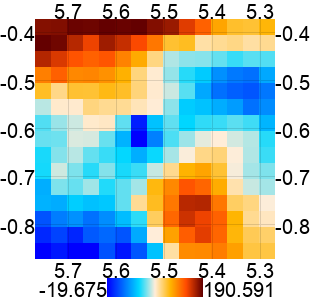

In [4]:
# Choose an object from the catalog
ra, dec = np.deg2rad([ras[16],decs[16]])
width = np.deg2rad(30/60.)

# Build the box around the object and cut out a submap from the larger map
box = [[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]]
stamp = imap.submap(box)

# Visualize the submap
# Note if using the full map you'll want to only upgrade by a factor of around 4
eshow(stamp, **{"upgrade": 16, "ticks": 0.1, "colorbar": True})

## Stacking point sources and using reproject

If we want to stack objects in the map it's relatively easy to do so, but we need to use a slightly different approach.  Instead of using a bounding box and cutting a submap from the map we can use pixell's reproject.postage_stamp function to cut out "stamps" that are reprojected at the center of each object. 

Reprojecting means that we avoid stacking point sources that are distorted due to the rectangular projection of the overall map, as the reprojection will automatically center the "stamp" on each individual point source. Users can specify the type of projection using the "proj" keyword. The default is a "gnomonic" projection, but since our stamp size is small, we can keep everything as "car" and continue to use our handy eshow function to build plots.

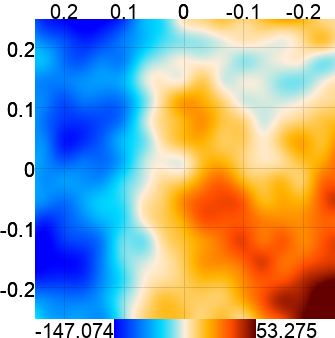

In [7]:
#Reproject the above source and plot
stamp = reproject.postage_stamp(inmap = imap , ra_deg = ras[16], dec_deg = decs[16], width_arcmin = 30.,
                  res_arcmin = .1, proj = 'car')
eshow(stamp, **{ "ticks": 0.1, "colorbar": True})

We see the utility of reproject.postage_stamp in action: the source is now centered in the new coordinates! Now we stack all of the reprojected sources:

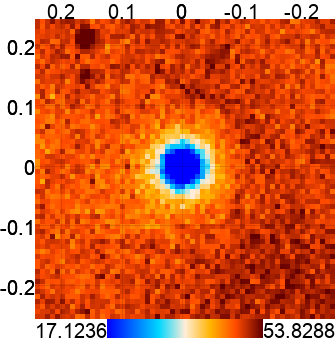

In [6]:
N = len(ras)
stack = 0

for i in range(N):
    # Extract stamps by reprojecting the map at the center of each source.
    # the 'postage_stamp' option here is designed to trim each reprojection so we
    # are left with a stack of point sources in a map of width 30 arc minutes
    stamp = reproject.postage_stamp(inmap = imap , ra_deg = ras[i], dec_deg = decs[i], width_arcmin = 30.,
                  res_arcmin = .5, proj = 'car')
    if stamp is None: continue
    stack += stamp[0]
    
stack /= N
eshow(stack, **{"upgrade": 5, "ticks": 0.1, "colorbar": True})

It looks like the average source in our catalog is a well-defined cold spot in the CMB. This is qualitatively consistent with our understanding of a typical thermal-SZ cluster observed at 150 GHz (see e.g. [this article](https://ned.ipac.caltech.edu/level5/Sept05/Carlstrom/Carlstrom2.html) from NED [CITATION]). We examine tSZ clusters in  more detail in [Section 6](Section_6_Component_separated_maps.ipynb).

## Plot Messier objects

While users are free to search for objects in the maps using catalogs we've also provided a tool to plot random Messier objects from our maps below.  You can enter the Messier number of an object you'd like to look at or feel free to let the function generate an object at random.

In [6]:
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import random 

In [7]:
def plot_messier(M = None):
    # M should be an integer 

    # read in a table of messier objects that overlap with our feild of view
    tbl = ascii.read(path + "messier_objs.csv", encoding = "utf-8-sig")

    # Check if user has given an object to look for
    if M != None:
        M = str('M') + str(M)
        A = list(tbl['M'])
        if M in A:
            obj = tbl[A.index(M)]
        else:
            print("Sorry that object isn't visible in this map")

    # If no object is given select a random one
    if M == None:
        obj = tbl[random.randrange(0, len(tbl))] 

    # Get the RA and DEC of the object
    ra = coord.Angle(obj["RA"], unit=u.hour) 
    dec = coord.Angle(obj["Declination"], unit = u.degree) 

    # Get a plot of the object
    stamp = reproject.postage_stamp(inmap = imap , ra_deg = ra.degree, \
              dec_deg = dec.degree, width_arcmin = 20., res_arcmin = .5)


    # Establish name for the object, if the common name is given use that, if not 
    # we just use the NGC and M indentifiers
    if type(obj["Common Name"] ) == np.str_:
        name = str(obj["Common Name"])  + str(' NGC: ') + str(obj["NGC"]) + \
        str(' ') + str(obj["M"])
    else:
        name = str('NGC: ') + str(obj["NGC"])+ str(' ') + str(obj["M"])

    # Plot the object 
    plt.imshow((stamp[0]))
    plt.title(name)
    plt.show()

    return 


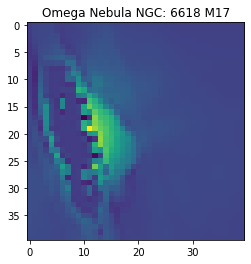

In [8]:
# Try this a few times - some of the objects may be clearer than others
plot_messier()

### Continue to the next section

[Section 5](Section_5_Lensing_maps.ipynb):  Introduction to the Lensing maps.